In [1]:
import os
os.sys.path.append('..')

In [2]:
import warnings
warnings.simplefilter("ignore")

# autoreload import your package
%load_ext autoreload
%autoreload 2

In [3]:
from loguru import logger
logger.remove()
logger.add(os.sys.stdout, level="ERROR", colorize=True, format="<level>{time} | {message}</level>")
# import_dir(ta_dir, verbose=False)
warnings.simplefilter("ignore")

In [4]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Args

In [5]:
from run import set_seed, get_args, Exp_Main

In [7]:
# mimic cli args to avoid code duplication
argv = """python -u run.py \
  --root_path ../dataset/stocks/ \
  --data_path OXY_2019.csv.gz \
  --checkpoints ./checkpoints/ \
  --model_id Exchange \
  --model ETSformer \
  --data custom \
  --features S \
  --seq_len 256 \
  --pred_len 48 \
  --e_layers 4 \
  --d_layers 4 \
  --enc_in 1 \
  --c_out 1 \
  --num_workers 0 \
  --des 'Exp' \
  --K 0 \
  --learning_rate 1e-4 \
  --target RSMKs_18_144_72_2ref_2ref \
  --itr 1
"""
argv = argv.replace("\\n", "").split()[3:]
args = get_args(argv)
args


Exp = Exp_Main
ii=0
set_seed(ii)
# setting record of experiments
setting = '{}_{}_{}_ft{}_sl{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_K{}_lr{}_{}_{}'.format(
    args.model_id,
    args.model,
    args.data,
    args.features,
    args.seq_len,
    args.pred_len,
    args.d_model,
    args.n_heads,
    args.e_layers,
    args.d_layers,
    args.d_ff,
    args.K,
    args.learning_rate,
    args.des, ii)

#     if os.path.exists(os.path.join(args.checkpoints, setting)):
#         print('skipping exists')
#         continue

exp = Exp(args)  # set experiments
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting, data='val')
exp.test(setting, data='test')

torch.cuda.empty_cache()

Args in experiment:
Namespace(K=0, activation='sigmoid', batch_size=32, c_out=1, checkpoints='./checkpoints/', d_ff=2048, d_layers=4, d_model=512, damping_learning_rate=0, data='custom', data_path='OXY_2019.csv.gz', dec_in=7, des="'Exp'", devices='0,1,2,3', dropout=0.2, e_layers=4, embed='timeF', enc_in=1, features='S', freq='h', gpu=0, itr=1, label_len=0, learning_rate=0.0001, lradj='exponential_with_warmup', min_lr=1e-30, model='ETSformer', model_id='Exchange', n_heads=8, num_workers=0, optim='adam', output_attention=False, patience=5, pred_len=48, root_path='../dataset/stocks/', seq_len=256, smoothing_learning_rate=0, std=0.2, target='RSMKs_18_144_72_2ref_2ref', train_epochs=15, use_gpu=True, use_multi_gpu=False, warmup_epochs=3)
Use GPU: cuda:0
>>>>>>>start training : Exchange_ETSformer_custom_ftS_sl256_pl48_dm512_nh8_el4_dl4_df2048_K0_lr0.0001_'Exp'_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 37075
val 5294
test 10632


  0%|          | 0/15 [00:00<?, ?epoch/s]

train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 1, Steps: 1158 | Train Loss: 0.3729197 Vali Loss: 0.0965895 Test Loss: 0.1416199
Validation loss decreased (inf --> 0.096589).  Saving model ...
Updating learning rate to 2.5e-05


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 2, Steps: 1158 | Train Loss: 0.2895640 Vali Loss: 0.0698275 Test Loss: 0.1066696
Validation loss decreased (0.096589 --> 0.069827).  Saving model ...
Updating learning rate to 5e-05


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 3, Steps: 1158 | Train Loss: 0.2814703 Vali Loss: 0.0588029 Test Loss: 0.0828039
Validation loss decreased (0.069827 --> 0.058803).  Saving model ...
Updating learning rate to 7.500000000000001e-05


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 4, Steps: 1158 | Train Loss: 0.2805967 Vali Loss: 0.0554975 Test Loss: 0.0784109
Validation loss decreased (0.058803 --> 0.055498).  Saving model ...
Updating learning rate to 0.0001


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 5, Steps: 1158 | Train Loss: 0.2617843 Vali Loss: 0.0553705 Test Loss: 0.0781345
Validation loss decreased (0.055498 --> 0.055370).  Saving model ...
Updating learning rate to 5e-05


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 6, Steps: 1158 | Train Loss: 0.2596816 Vali Loss: 0.0536334 Test Loss: 0.0759336
Validation loss decreased (0.055370 --> 0.053633).  Saving model ...
Updating learning rate to 2.5e-05


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 7, Steps: 1158 | Train Loss: 0.2558732 Vali Loss: 0.0516733 Test Loss: 0.0734066
Validation loss decreased (0.053633 --> 0.051673).  Saving model ...
Updating learning rate to 1.25e-05


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 8, Steps: 1158 | Train Loss: 0.2663585 Vali Loss: 0.0526782 Test Loss: 0.0746597
EarlyStopping counter: 1 out of 5
Updating learning rate to 6.25e-06


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 9, Steps: 1158 | Train Loss: 0.2524643 Vali Loss: 0.0532676 Test Loss: 0.0754930
EarlyStopping counter: 2 out of 5
Updating learning rate to 3.125e-06


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 10, Steps: 1158 | Train Loss: 0.2388380 Vali Loss: 0.0524606 Test Loss: 0.0746193
EarlyStopping counter: 3 out of 5
Updating learning rate to 1.5625e-06


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 11, Steps: 1158 | Train Loss: 0.2432093 Vali Loss: 0.0529288 Test Loss: 0.0752425
EarlyStopping counter: 4 out of 5
Updating learning rate to 7.8125e-07


train:   0%|          | 0/1158 [00:00<?, ?it/s]

Epoch: 12, Steps: 1158 | Train Loss: 0.2591919 Vali Loss: 0.0529958 Test Loss: 0.0752713
EarlyStopping counter: 5 out of 5
Early stopping
>>>>>>>testing : Exchange_ETSformer_custom_ftS_sl256_pl48_dm512_nh8_el4_dl4_df2048_K0_lr0.0001_'Exp'_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
val 5294
loading model


  0%|          | 0/165 [00:00<?, ?it/s]

test shape: (165, 32, 48, 1) (165, 32, 48, 1)
test shape: (5280, 48, 1) (5280, 48, 1)
mse:0.05175326019525528, mae:0.15480808913707733
test 10632
loading model


  0%|          | 0/332 [00:00<?, ?it/s]

test shape: (332, 32, 48, 1) (332, 32, 48, 1)
test shape: (10624, 48, 1) (10624, 48, 1)
mse:0.07340655475854874, mae:0.18461503088474274


# Plot

In [8]:
setting

"Exchange_ETSformer_custom_ftS_sl256_pl48_dm512_nh8_el4_dl4_df2048_K0_lr0.0001_'Exp'_0"

In [9]:
ds, dl = exp._get_data('test')

test 10632


In [10]:
preds, trues = exp.test(setting, data='test')

test 10632
loading model


  0%|          | 0/332 [00:00<?, ?it/s]

test shape: (332, 32, 48, 1) (332, 32, 48, 1)
test shape: (10624, 48, 1) (10624, 48, 1)
mse:0.07340655475854874, mae:0.18461503088474274


In [11]:
%matplotlib inline

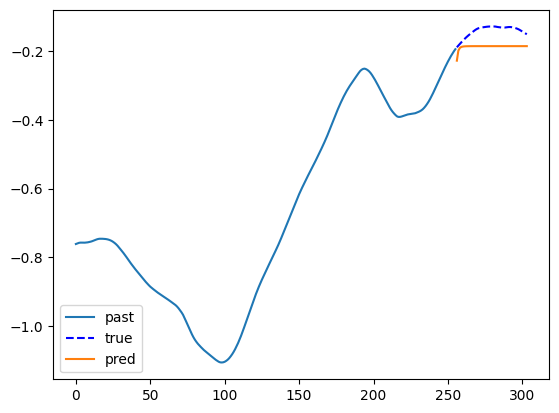

In [12]:
i=990
(batch_x, batch_y, batch_x_mark, batch_y_mark)  = ds[i]
l1 = batch_x.shape[0]
l2 = batch_y.shape[0]
plt.plot(range(l1), batch_x[:, -1], label='past')
plt.plot(range(l1, l1+l2), batch_y[:, -1], color='blue', ls='--', label='true')
plt.plot(range(l1, l1+l2), preds[i], label='pred');
plt.legend(loc='lower left')

# TODO check index

- s_end = index + self.seq_len
- r_begin = index + self.seq_len - self.label_len
- r_end = index + self.seq_len + self.pred_len

In [13]:
f = ds.root_path + '/' + ds.data_path
df = pd.read_csv(f).set_index('date', drop=False)
df = df[ds.cols[1:]]
# df[:] = ds.scaler.transform(df.values)
df
# df

,close,ref_close,sec_close,RVOLs_50_12_2ref_2ref,MACDVs_3_10_9_2ref_2ref,MACDVs_8_24_9_2ref_2ref,RRVOLs_50_12_2ref_2ref,RSMKs_3_24_12_2ref_2ref,RSMKs_128_8_4_2ref_2ref,RRSs_12_12_12_2ref_2ref,VRRSs_5_21_12_2ref_2ref,RSMKs_18_144_72_2ref_2ref
date,,,,,,,,,,,,
2019-01-02 07:00:00,60.7500,246.3900,56.70,0.634561,0.228822,0.749770,-0.081572,0.754948,0.041974,0.452882,0.094300,-0.141763
2019-01-02 09:30:00,60.2000,246.3000,56.30,0.619485,-0.138271,0.516611,-0.159545,0.690752,0.037310,0.201226,-0.050731,-0.127774
2019-01-02 09:35:00,59.8500,246.5200,56.36,0.689500,-0.535564,0.191501,-0.104752,0.553376,0.027199,-0.217425,-0.069932,-0.117113
2019-01-02 09:40:00,60.0600,246.9001,56.70,0.746596,-0.803242,-0.130051,-0.070761,0.402911,0.015511,-0.473000,-0.089949,-0.109966
2019-01-02 09:45:00,60.2350,247.1400,56.69,0.701637,-0.936439,-0.409001,-0.130581,0.263664,0.003868,-0.679096,-0.096488,-0.105561
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 17:35:00,17.3300,374.2100,37.90,0.706492,-0.129955,-0.551704,0.197178,-0.842459,-0.216290,-3.579407,-0.088556,-1.118991
2020-12-31 18:30:00,17.3200,374.4000,37.96,0.615936,-0.147461,-0.538942,0.174563,-0.803874,-0.213881,-3.258388,-0.075389,-1.179880
2020-12-31 19:15:00,17.3600,374.3900,37.95,0.605291,-0.105155,-0.508192,0.226633,-0.756699,-0.210656,-2.735903,-0.063731,-1.239256


In [14]:
from data_provider.data_loader import Dataset_Custom
ds2 = Dataset_Custom(
    ds.root_path,
    flag="test",
#     size=ds.size,
    size=[ds.seq_len, ds.label_len, ds.pred_len],
    features=ds.features,
    data_path=ds.data_path,
    target=ds.target,
    scale=False,
    timeenc=ds.timeenc,
    freq=ds.freq
)

i=99
(batch_x, batch_y, batch_x_mark, batch_y_mark)  = ds2[i]
batch_x[-1]

array([-3.5727635])

In [17]:
ds.target

'RSMKs_18_144_72_2ref_2ref'

In [18]:
ds.cols

['date',
 'close',
 'ref_close',
 'sec_close',
 'RVOLs_50_12_2ref_2ref',
 'MACDVs_3_10_9_2ref_2ref',
 'MACDVs_8_24_9_2ref_2ref',
 'RRVOLs_50_12_2ref_2ref',
 'RSMKs_3_24_12_2ref_2ref',
 'RSMKs_128_8_4_2ref_2ref',
 'RRSs_12_12_12_2ref_2ref',
 'VRRSs_5_21_12_2ref_2ref',
 'RSMKs_18_144_72_2ref_2ref']

In [15]:
dt = ds2.index.iloc[i-1]
df.loc[dt]

close                         12.425000
ref_close                    354.330000
sec_close                     35.270000
RVOLs_50_12_2ref_2ref          0.624195
MACDVs_3_10_9_2ref_2ref       -0.120630
MACDVs_8_24_9_2ref_2ref        0.464484
RRVOLs_50_12_2ref_2ref        -0.396678
RSMKs_3_24_12_2ref_2ref        1.041695
RSMKs_128_8_4_2ref_2ref       -0.028802
RRSs_12_12_12_2ref_2ref       -0.461073
VRRSs_5_21_12_2ref_2ref       -0.009818
RSMKs_18_144_72_2ref_2ref     -3.572763
Name: 2020-09-02 11:20:00, dtype: float64

In [16]:
assert df.loc[dt].close == batch_x[-1, 0], 'index should be right'
'OK'

AssertionError: index should be right